In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

from torchinfo import summary
from going_modular import data_setup, engine

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
device

'cuda'

In [4]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [5]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [6]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x2c51c9ea690>,
 ['pizza', 'steak', 'sushi'])

In [7]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights (plenty of these available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = weights.transforms() 
print(f"Automatically created transforms: {automatic_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, # use automatic created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x2c5245bb490>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Create the pretrained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [9]:
# Freeze all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False
    
# Since we're creating a new layer with random weights (torch.nn.Linear), 
# let's set the seeds
set_seeds() 

# Update the classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=len(class_names),
              bias=True).to(device))

In [10]:
from torchinfo import summary

# # Get a summary of the model (uncomment for full output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [11]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [13]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    # Close the writer
    writer.close()
    
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [14]:
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0962 | train_acc: 0.3906 | test_loss: 0.9144 | test_acc: 0.5909


 20%|██        | 1/5 [00:16<01:07, 16.79s/it]

Epoch: 2 | train_loss: 0.9046 | train_acc: 0.6445 | test_loss: 0.7883 | test_acc: 0.8258


 40%|████      | 2/5 [00:32<00:49, 16.43s/it]

Epoch: 3 | train_loss: 0.8096 | train_acc: 0.7344 | test_loss: 0.6768 | test_acc: 0.8864


 60%|██████    | 3/5 [00:48<00:32, 16.18s/it]

Epoch: 4 | train_loss: 0.6849 | train_acc: 0.8633 | test_loss: 0.6739 | test_acc: 0.8049


 80%|████████  | 4/5 [01:04<00:16, 16.02s/it]

Epoch: 5 | train_loss: 0.7079 | train_acc: 0.7266 | test_loss: 0.6792 | test_acc: 0.7737


100%|██████████| 5/5 [01:20<00:00, 16.06s/it]


In [15]:
# Check out the model results
results

{'train_loss': [1.0961900874972343,
  0.9045922607183456,
  0.8096145987510681,
  0.6848607212305069,
  0.7079475931823254],
 'train_acc': [0.390625, 0.64453125, 0.734375, 0.86328125, 0.7265625],
 'test_loss': [0.9143900473912557,
  0.7882702747980753,
  0.6768401066462199,
  0.6739216446876526,
  0.6792443990707397],
 'test_acc': [0.5909090909090909,
  0.8257575757575758,
  0.8863636363636364,
  0.8049242424242425,
  0.7736742424242425]}

In [16]:
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [17]:
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")

[INFO] Created SummaryWriter, saving to: runs\2024-03-12\data_10_percent\effnetb0\5_epochs...


In [18]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [20]:
os.cpu_count()

12

In [21]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data\pizza_steak_sushi directory exists, skipping download.
[INFO] Did not find data\pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [22]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train" 
train_dir_20_percent = data_20_percent_path / "train" 

# Setup testing directory paths (both use the same)
test_dir = data_10_percent_path / "test" 

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data\pizza_steak_sushi\train
Training directory 20%: data\pizza_steak_sushi_20_percent\train
Testing directory: data\pizza_steak_sushi\test


In [23]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

In [24]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


In [25]:
import torchvision
from torchinfo import summary

effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to C:\Users\alexa/.cache\torch\hub\checkpoints\efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:04<00:00, 7.77MB/s]


Number of in_features to final layer of EfficientNetB2: 1408


In [27]:
summary(model=effnetb2,
        input_size=(32, 3, 224, 224),
        col_names=["input_size"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]
├─Sequential (features)                                      [32, 3, 224, 224]
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]
│    │    └─SiLU (2)                                         [32, 32, 112, 112]
│    └─Sequential (1)                                        [32, 32, 112, 112]
│    │    └─MBConv (0)                                       [32, 32, 112, 112]
│    │    └─MBConv (1)                                       [32, 16, 112, 112]
│    └─Sequential (2)                                        [32, 16, 112, 112]
│    │    └─MBConv (0)                                       [32, 16, 112, 112]
│    │    └─MBConv (1)                             

In [29]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

def create_effnetb0():
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [30]:
effnetb0 = create_effnetb0()

summary(model=effnetb0)

[INFO] Created new effnetb0 model.


Layer (type:depth-idx)                                  Param #
EfficientNet                                            --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 (864)
│    │    └─BatchNorm2d: 3-2                            (64)
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─MBConv: 3-4                                 (1,448)
│    └─Sequential: 2-3                                  --
│    │    └─MBConv: 3-5                                 (6,004)
│    │    └─MBConv: 3-6                                 (10,710)
│    └─Sequential: 2-4                                  --
│    │    └─MBConv: 3-7                                 (15,350)
│    │    └─MBConv: 3-8                                 (31,290)
│    └─Sequential: 2-5                                  --
│    │    └─MBConv

In [31]:
effnetb2 = create_effnetb2()

summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

[INFO] Created new effnetb2 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [32]:
# Create epochs list
num_epochs = [5, 10]

# Create models list
models = ["effnetb0", "effnetb2"]

# Create dataloaders dictionary
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [35]:
%%time
from going_modular.utils import save_model

# 1 set the random seeds
set_seeds(42)

# 2 Keep track of experiment numbers
experiment_number = 0

# 3 Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4 Loop through each number of epochs
    for epochs in num_epochs:

        # 5 Loop through each model name
        for model_name in models:

            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2024-03-12\data_10_percent\effnetb0\5_epochs...


 20%|██        | 1/5 [00:15<01:03, 15.99s/it]

Epoch: 1 | train_loss: 1.0528 | train_acc: 0.4961 | test_loss: 0.9217 | test_acc: 0.4678


 40%|████      | 2/5 [00:35<00:54, 18.20s/it]

Epoch: 2 | train_loss: 0.8747 | train_acc: 0.6992 | test_loss: 0.8138 | test_acc: 0.6203


 60%|██████    | 3/5 [00:51<00:34, 17.13s/it]

Epoch: 3 | train_loss: 0.8099 | train_acc: 0.6445 | test_loss: 0.7175 | test_acc: 0.8258


 80%|████████  | 4/5 [01:06<00:16, 16.42s/it]

Epoch: 4 | train_loss: 0.7098 | train_acc: 0.7578 | test_loss: 0.5898 | test_acc: 0.8864


100%|██████████| 5/5 [01:22<00:00, 16.48s/it]

Epoch: 5 | train_loss: 0.5981 | train_acc: 0.9141 | test_loss: 0.5676 | test_acc: 0.8864
[INFO] Saving model to: models\07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2024-03-12\data_10_percent\effnetb2\5_epochs...


 20%|██        | 1/5 [00:14<00:56, 14.01s/it]

Epoch: 1 | train_loss: 1.0927 | train_acc: 0.3711 | test_loss: 0.9557 | test_acc: 0.6610


 40%|████      | 2/5 [00:27<00:41, 13.81s/it]

Epoch: 2 | train_loss: 0.9247 | train_acc: 0.6445 | test_loss: 0.8711 | test_acc: 0.8144


 60%|██████    | 3/5 [00:41<00:27, 13.62s/it]

Epoch: 3 | train_loss: 0.8086 | train_acc: 0.7656 | test_loss: 0.7510 | test_acc: 0.9176


 80%|████████  | 4/5 [00:54<00:13, 13.48s/it]

Epoch: 4 | train_loss: 0.7191 | train_acc: 0.8867 | test_loss: 0.7149 | test_acc: 0.9081


100%|██████████| 5/5 [01:07<00:00, 13.51s/it]

Epoch: 5 | train_loss: 0.6850 | train_acc: 0.7695 | test_loss: 0.7075 | test_acc: 0.8873
[INFO] Saving model to: models\07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2024-03-12\data_10_percent\effnetb0\10_epochs...


 10%|█         | 1/10 [00:13<01:59, 13.31s/it]

Epoch: 1 | train_loss: 1.0528 | train_acc: 0.4961 | test_loss: 0.9217 | test_acc: 0.4678


 20%|██        | 2/10 [00:27<01:50, 13.83s/it]

Epoch: 2 | train_loss: 0.8747 | train_acc: 0.6992 | test_loss: 0.8138 | test_acc: 0.6203


 30%|███       | 3/10 [00:43<01:42, 14.60s/it]

Epoch: 3 | train_loss: 0.8099 | train_acc: 0.6445 | test_loss: 0.7175 | test_acc: 0.8258


 40%|████      | 4/10 [00:57<01:26, 14.47s/it]

Epoch: 4 | train_loss: 0.7098 | train_acc: 0.7578 | test_loss: 0.5898 | test_acc: 0.8864


 50%|█████     | 5/10 [01:10<01:10, 14.15s/it]

Epoch: 5 | train_loss: 0.5981 | train_acc: 0.9141 | test_loss: 0.5676 | test_acc: 0.8864


 60%|██████    | 6/10 [01:24<00:55, 13.95s/it]

Epoch: 6 | train_loss: 0.5611 | train_acc: 0.8984 | test_loss: 0.5949 | test_acc: 0.8864


 70%|███████   | 7/10 [01:37<00:41, 13.71s/it]

Epoch: 7 | train_loss: 0.5574 | train_acc: 0.7930 | test_loss: 0.5566 | test_acc: 0.8864


 80%|████████  | 8/10 [01:50<00:27, 13.56s/it]

Epoch: 8 | train_loss: 0.4702 | train_acc: 0.9492 | test_loss: 0.5177 | test_acc: 0.8759


 90%|█████████ | 9/10 [02:07<00:14, 14.58s/it]

Epoch: 9 | train_loss: 0.5728 | train_acc: 0.7773 | test_loss: 0.5094 | test_acc: 0.8873


100%|██████████| 10/10 [02:22<00:00, 14.22s/it]

Epoch: 10 | train_loss: 0.4795 | train_acc: 0.8242 | test_loss: 0.4640 | test_acc: 0.9072
[INFO] Saving model to: models\07_effnetb0_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2024-03-12\data_10_percent\effnetb2\10_epochs...


 10%|█         | 1/10 [00:13<02:01, 13.48s/it]

Epoch: 1 | train_loss: 1.0927 | train_acc: 0.3711 | test_loss: 0.9557 | test_acc: 0.6610


 20%|██        | 2/10 [00:26<01:47, 13.45s/it]

Epoch: 2 | train_loss: 0.9247 | train_acc: 0.6445 | test_loss: 0.8711 | test_acc: 0.8144


 30%|███       | 3/10 [00:40<01:34, 13.44s/it]

Epoch: 3 | train_loss: 0.8086 | train_acc: 0.7656 | test_loss: 0.7510 | test_acc: 0.9176


 40%|████      | 4/10 [00:53<01:20, 13.43s/it]

Epoch: 4 | train_loss: 0.7191 | train_acc: 0.8867 | test_loss: 0.7149 | test_acc: 0.9081


 50%|█████     | 5/10 [01:07<01:07, 13.49s/it]

Epoch: 5 | train_loss: 0.6850 | train_acc: 0.7695 | test_loss: 0.7075 | test_acc: 0.8873


 60%|██████    | 6/10 [01:20<00:53, 13.49s/it]

Epoch: 6 | train_loss: 0.6111 | train_acc: 0.7812 | test_loss: 0.6325 | test_acc: 0.9280


 70%|███████   | 7/10 [01:34<00:40, 13.45s/it]

Epoch: 7 | train_loss: 0.6127 | train_acc: 0.8008 | test_loss: 0.6403 | test_acc: 0.8769


 80%|████████  | 8/10 [01:47<00:26, 13.47s/it]

Epoch: 8 | train_loss: 0.5202 | train_acc: 0.9336 | test_loss: 0.6199 | test_acc: 0.8977


 90%|█████████ | 9/10 [02:01<00:13, 13.44s/it]

Epoch: 9 | train_loss: 0.5426 | train_acc: 0.8008 | test_loss: 0.6226 | test_acc: 0.8466


100%|██████████| 10/10 [02:14<00:00, 13.45s/it]

Epoch: 10 | train_loss: 0.4908 | train_acc: 0.8125 | test_loss: 0.5871 | test_acc: 0.8873
[INFO] Saving model to: models\07_effnetb2_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 5
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5


[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2024-03-12\data_20_percent\effnetb0\5_epochs...


 20%|██        | 1/5 [00:14<00:59, 14.93s/it]

Epoch: 1 | train_loss: 0.9576 | train_acc: 0.6167 | test_loss: 0.6545 | test_acc: 0.8655


 40%|████      | 2/5 [00:28<00:42, 14.25s/it]

Epoch: 2 | train_loss: 0.6881 | train_acc: 0.8438 | test_loss: 0.5799 | test_acc: 0.9176


 60%|██████    | 3/5 [00:42<00:28, 14.06s/it]

Epoch: 3 | train_loss: 0.5798 | train_acc: 0.8625 | test_loss: 0.4576 | test_acc: 0.9176


 80%|████████  | 4/5 [00:56<00:13, 13.97s/it]

Epoch: 4 | train_loss: 0.4930 | train_acc: 0.8646 | test_loss: 0.4459 | test_acc: 0.9176


100%|██████████| 5/5 [01:10<00:00, 14.04s/it]

Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.3909 | test_acc: 0.9176
[INFO] Saving model to: models\07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2024-03-12\data_20_percent\effnetb2\5_epochs...


 20%|██        | 1/5 [00:14<00:57, 14.30s/it]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5542 | test_loss: 0.7768 | test_acc: 0.8153


 40%|████      | 2/5 [00:28<00:42, 14.03s/it]

Epoch: 2 | train_loss: 0.7299 | train_acc: 0.7604 | test_loss: 0.6673 | test_acc: 0.8873


 60%|██████    | 3/5 [00:42<00:28, 14.01s/it]

Epoch: 3 | train_loss: 0.6022 | train_acc: 0.8458 | test_loss: 0.5622 | test_acc: 0.9280


 80%|████████  | 4/5 [00:56<00:14, 14.06s/it]

Epoch: 4 | train_loss: 0.5436 | train_acc: 0.8354 | test_loss: 0.5678 | test_acc: 0.9186


100%|██████████| 5/5 [01:10<00:00, 14.07s/it]

Epoch: 5 | train_loss: 0.4404 | train_acc: 0.9042 | test_loss: 0.4461 | test_acc: 0.9489
[INFO] Saving model to: models\07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2024-03-12\data_20_percent\effnetb0\10_epochs...


 10%|█         | 1/10 [00:13<02:04, 13.81s/it]

Epoch: 1 | train_loss: 0.9576 | train_acc: 0.6167 | test_loss: 0.6545 | test_acc: 0.8655


 20%|██        | 2/10 [00:27<01:50, 13.78s/it]

Epoch: 2 | train_loss: 0.6881 | train_acc: 0.8438 | test_loss: 0.5799 | test_acc: 0.9176


 30%|███       | 3/10 [00:41<01:36, 13.78s/it]

Epoch: 3 | train_loss: 0.5798 | train_acc: 0.8625 | test_loss: 0.4576 | test_acc: 0.9176


 40%|████      | 4/10 [00:55<01:22, 13.82s/it]

Epoch: 4 | train_loss: 0.4930 | train_acc: 0.8646 | test_loss: 0.4459 | test_acc: 0.9176


 50%|█████     | 5/10 [01:09<01:09, 13.85s/it]

Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.3909 | test_acc: 0.9176


 60%|██████    | 6/10 [01:23<00:56, 14.16s/it]

Epoch: 6 | train_loss: 0.3705 | train_acc: 0.8854 | test_loss: 0.3568 | test_acc: 0.9072


 70%|███████   | 7/10 [01:37<00:42, 14.06s/it]

Epoch: 7 | train_loss: 0.3551 | train_acc: 0.9250 | test_loss: 0.3186 | test_acc: 0.9072


 80%|████████  | 8/10 [01:51<00:27, 13.97s/it]

Epoch: 8 | train_loss: 0.3745 | train_acc: 0.8938 | test_loss: 0.3349 | test_acc: 0.8873


 90%|█████████ | 9/10 [02:05<00:13, 13.91s/it]

Epoch: 9 | train_loss: 0.2972 | train_acc: 0.9396 | test_loss: 0.3093 | test_acc: 0.9280


100%|██████████| 10/10 [02:20<00:00, 14.05s/it]

Epoch: 10 | train_loss: 0.3620 | train_acc: 0.8479 | test_loss: 0.2780 | test_acc: 0.9072
[INFO] Saving model to: models\07_effnetb0_data_20_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 8
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2024-03-12\data_20_percent\effnetb2\10_epochs...


 10%|█         | 1/10 [00:14<02:06, 14.09s/it]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5542 | test_loss: 0.7768 | test_acc: 0.8153


 20%|██        | 2/10 [00:28<01:52, 14.04s/it]

Epoch: 2 | train_loss: 0.7299 | train_acc: 0.7604 | test_loss: 0.6673 | test_acc: 0.8873


 30%|███       | 3/10 [00:42<01:38, 14.00s/it]

Epoch: 3 | train_loss: 0.6022 | train_acc: 0.8458 | test_loss: 0.5622 | test_acc: 0.9280


 40%|████      | 4/10 [00:55<01:23, 13.93s/it]

Epoch: 4 | train_loss: 0.5436 | train_acc: 0.8354 | test_loss: 0.5678 | test_acc: 0.9186


 50%|█████     | 5/10 [01:09<01:09, 13.97s/it]

Epoch: 5 | train_loss: 0.4404 | train_acc: 0.9042 | test_loss: 0.4461 | test_acc: 0.9489


 60%|██████    | 6/10 [01:23<00:55, 13.98s/it]

Epoch: 6 | train_loss: 0.3889 | train_acc: 0.9104 | test_loss: 0.4554 | test_acc: 0.8977


 70%|███████   | 7/10 [01:37<00:41, 13.96s/it]

Epoch: 7 | train_loss: 0.3483 | train_acc: 0.9271 | test_loss: 0.4228 | test_acc: 0.9384


 80%|████████  | 8/10 [01:51<00:28, 14.00s/it]

Epoch: 8 | train_loss: 0.3861 | train_acc: 0.8771 | test_loss: 0.4344 | test_acc: 0.9280


 90%|█████████ | 9/10 [02:05<00:14, 14.01s/it]

Epoch: 9 | train_loss: 0.3308 | train_acc: 0.8979 | test_loss: 0.4241 | test_acc: 0.9384


100%|██████████| 10/10 [02:19<00:00, 13.98s/it]

Epoch: 10 | train_loss: 0.3383 | train_acc: 0.8896 | test_loss: 0.3906 | test_acc: 0.9384
[INFO] Saving model to: models\07_effnetb2_data_20_percent_10_epochs.pth
--------------------------------------------------

CPU times: total: 1min 11s
Wall time: 14min 9s


In [37]:
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth" 

best_model = create_effnetb2()

best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [38]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


cuda


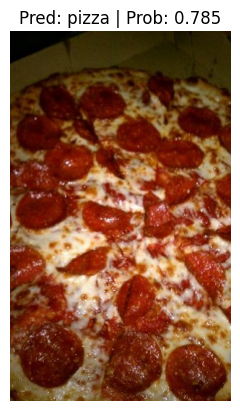

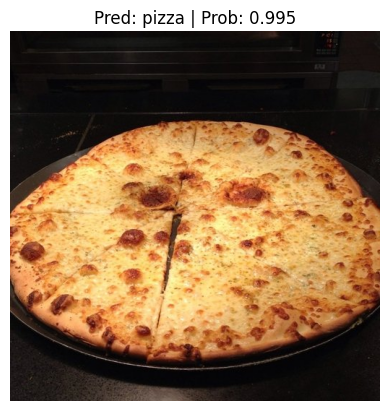

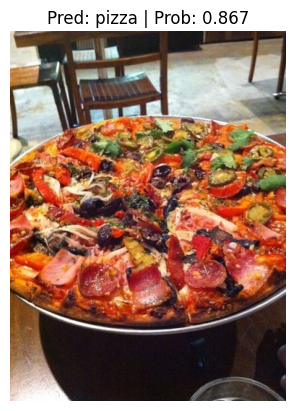

In [45]:
from going_modular.experiment import pred_and_plot_image
import random

print(device)
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224),
                        device=device)

data\04-pizza-dad.jpeg already exists, skipping download.


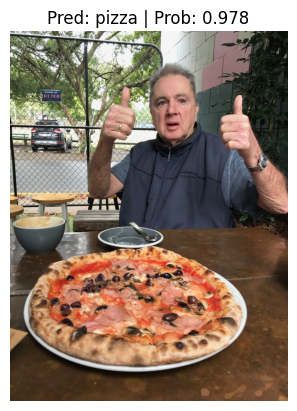

In [46]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)